# Анализ оттока клиентов

**Задача:** проанализировать клиентов регионального банка и выделить сегменты клиентов,
которые склонны уходить из банка

## Загрузка данных

In [1]:
#отключим предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
!pip install phik 
import phik
from phik import phik_matrix

In [3]:
# чтение файла
data = pd.read_csv('/datasets/bank_scrooge.csv')

In [4]:
# отображение датафрейма и информации о нем
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


## Предобработка данных

### Проверка пропусков

Заметим, что есть пропуски в age и balance

In [5]:
# переименуем столбцы
data = data.rename(columns={'USERID':'user_id', 'EST_SALARY':'salary'})

In [6]:
# количество пропусков в возрасте
data['age'].isna().sum()

26

In [7]:
# Пропусков в возрасте очень мало, поэтому можно просто удалить строки с этими пропусками
data = data.dropna(subset=['age'])

In [8]:
# количество пропусков в balance
data['balance'].isna().sum()

2279

Пропусков в балансе много, поэтому просто удалить их нельзя. Найдем способ, чтобы их заполнить

In [9]:
#Создадим столбец flag_nan_balance, который принимает 0, если в столбце balance пропуск и 1, если пропуска нет
data['flag_nan_balance'] = data['balance'].isnull()
data['flag_nan_balance'] = data['flag_nan_balance'].apply(lambda x: 0 if x == True else 1)

In [10]:
data

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,flag_nan_balance
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,1
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0,1
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0,1


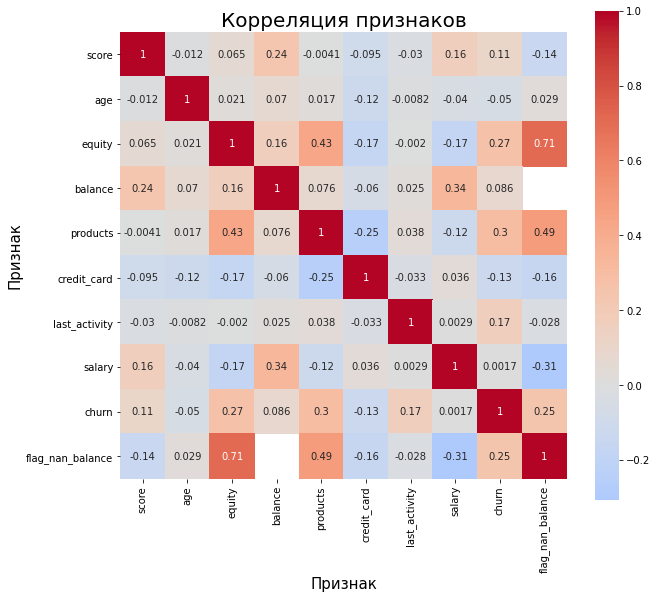

In [11]:
# Создадим таблицу корреляции и посмотрим, какой от какого показателя больше всего зависит столбец flag_nan_balance
cm = data.loc[:, data.columns != 'user_id'].corr()
fig, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(cm, annot=True, square=True, cmap='coolwarm', center=0)
plt.title('Корреляция признаков', fontsize = 20)
plt.xlabel('Признак', fontsize = 15)
plt.ylabel('Признак', fontsize = 15); 


По таблице видим, что самая большая корреляция - со значением equity (количество баллов собственности). Чем больше баллов собственности, тем больше баланс счета.

Кроме того, пропуски относятся к  MNAR (Missing Not At Random / Отсутствует не случайно) — пропуски зависят от данных, без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям.
Поэтму пропуски нужно заполнить.

### Заполнение пропусков

In [12]:
# посмотрим, что из себя представляет велицина equity
data['equity'].unique()

array([1, 5, 0, 4, 3, 2, 6, 7, 8, 9])

Поскольку equity - категориальная величина, мы можем заполнить пропуски в balance в зависимости от equity

In [13]:
# заполним пропуски медианным значением про equity
for money in data['equity'].unique():
    median = data.loc[data['equity'] == money, 'balance'].median()
    data.loc[(data['balance'].isna()) & (data['equity'] == money), 'balance'] = median

# выведем количество пропусков после их заполнения    
data['balance'].isna().sum()

0

### Выявление и удаление дубликатов

In [14]:
# количество полных дубликатов
data.duplicated().sum()

0

In [15]:
#Определим количество неявных дубликатов
#Найдем дубликаты в user_id
data.duplicated(['user_id']).sum()

50

Таких оказалось 50 человек. Так же заметим, что в таблице указывается город. То есть, если один и тот же человек ходит в отделения банка в разных городах, то он продублируется в таблице.

In [16]:
# Проверим количество user_id, у которых также совпадает город
data.duplicated(['user_id', 'city']).sum()

0

Таких клиентов не оказалось, поэтому удалять этих 50 человек мы не будем.

### Выявление и удаление аномалий

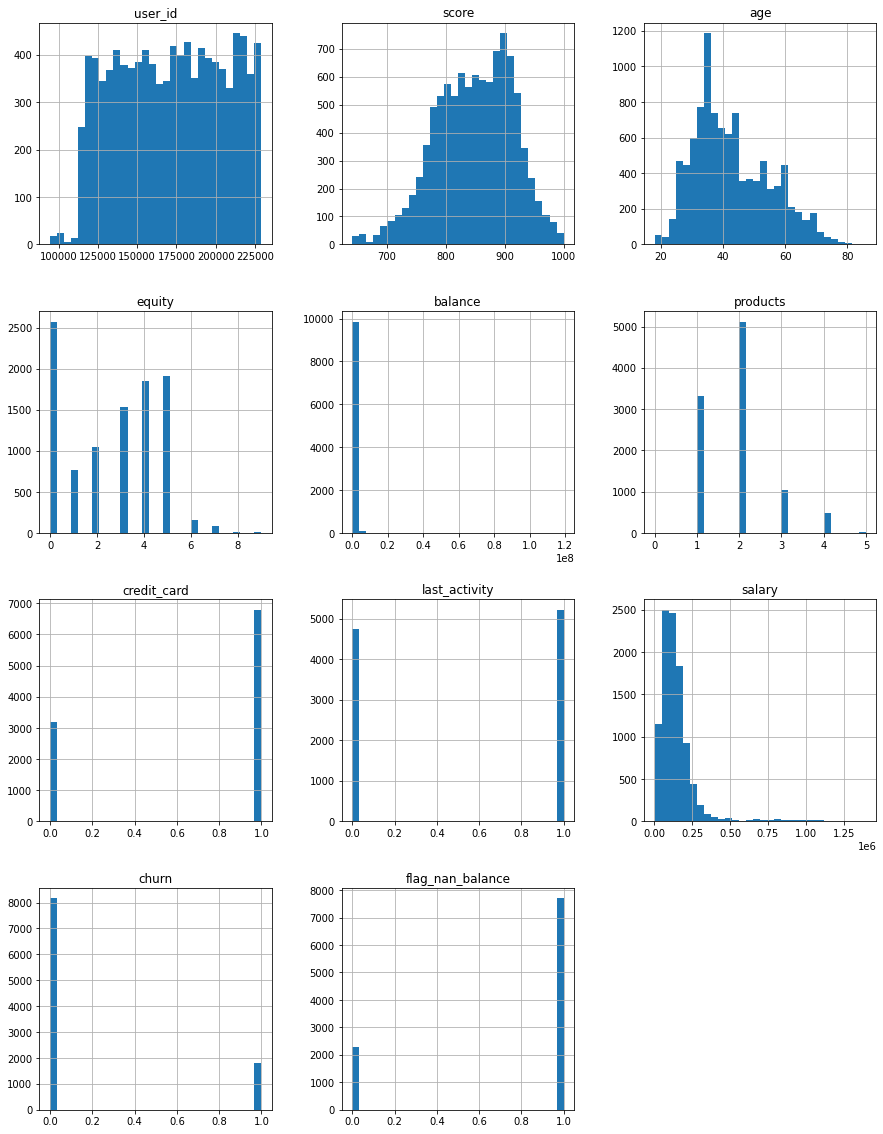

In [17]:
# Оценим визуально распределения каждого из графиков
data.hist(figsize=(15, 20), bins=30);

У столбцов user_id, equity, age, credit_card, last_activity, salary, churn и flag_nan_balance нет аномалий. А вот к остальным стобцам: score, balance и product лучше присмотреться внимательнее.

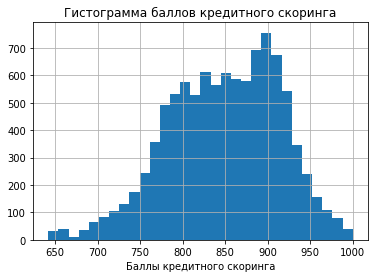

In [18]:
data['score'].hist(bins=30)
plt.title('Гистограмма баллов кредитного скоринга')
plt.xlabel('Баллы кредитного скоринга');

Аномалий нет

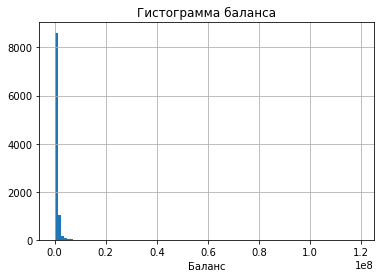

In [19]:
data['balance'].hist(bins=100)
plt.title('Гистограмма баланса')
plt.xlabel('Баланс');

Есть некоторые клиенты с очень большим счетом. Определим их количество:

In [20]:
data.query('balance > 5000000')['user_id'].count()

72

Таких всего 72 человека, для анализа они не помешают, так как мы будем брать медиану, а не среднее значение. Оставляем их

In [21]:
data['products'].unique()

array([2, 3, 1, 4, 5, 0])

Не может быть клиента банка, с отсутсвием кредитных продуктов. В этом случае это уже не клиент. Следовательно 0 продуктов - это аномалия.

In [22]:
# Посмотрим сколько клиентов имеют 0 продуктов
data.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,flag_nan_balance
8957,147837,962.0,Рыбинск,Ж,79.0,3,463796.54,0,0,0,25063.96,1,0


In [23]:
#Всего один клиент. Удалим его:
data = data.query('products > 0').reset_index(drop=True)

**Подытожим.** Для подготовки данных к анализу потребовалось:
-  Переименовать 2 столбца
-  Удалить 26 пропусков в столбце age;
-  Заполнить 2279 пропусков в столбце balance (по медиане, в зависимости от столбца equity)
-  Удалить аномалию (1 строка, где в products=0) 


## Анализ данных (EDA)

### Анализ распределения
Анализируем с точки зрения оттока. Для непрерывных величин ищем отточные интервалы, для категориальныых или дискретных - ищем значения признаков с оттоком выше, чем по банку

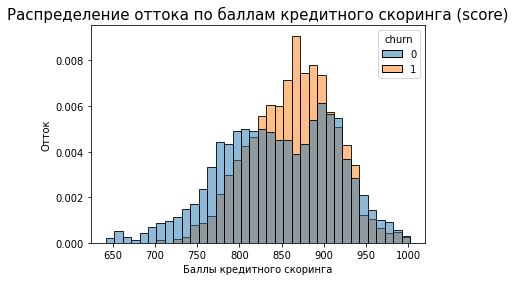

In [24]:
#распределение оттока по баллам кредитного скоринга (score):
sns.histplot(data=data, x='score', hue='churn', stat='density', common_norm=False, binwidth=10)
plt.title('Распределение оттока по баллам кредитного скоринга (score)', fontsize=15)
plt.xlabel('Баллы кредитного скоринга')
plt.ylabel('Отток');


На графике видно, что отток больше среднего по банку в промежутке с 820 до 900 баллов кредитного скоринга.

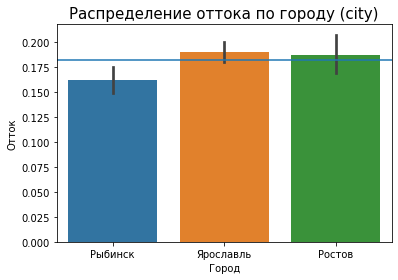

In [25]:
# распределение оттока по городу(city)
sns.barplot(data = data, x='city', y='churn')
mean = data['churn'].mean()
plt.axhline(y=mean)
plt.title('Распределение оттока по городу (city)', fontsize=15)
plt.xlabel('Город')
plt.ylabel('Отток');

На графике видно, что отток больше среднего по банку в Ярославле и Ростове

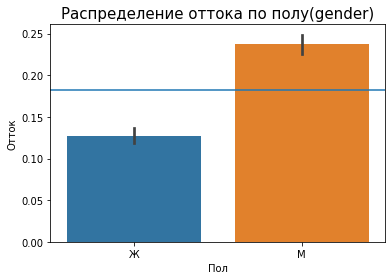

In [26]:
# распределение оттока по полу(gender)
sns.barplot(data = data, x='gender', y='churn')
mean = data['churn'].mean()
plt.axhline(y=mean)
plt.title('Распределение оттока по полу(gender)', fontsize=15)
plt.xlabel('Пол')
plt.ylabel('Отток');

На графике видно, что отток больше среднего по банку среди мужчин

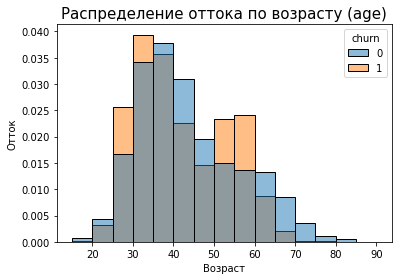

In [27]:
#распределение оттока по возрасту (age):
sns.histplot(data=data, x='age', hue='churn', stat='density', common_norm=False, binwidth=5, binrange=(15, 90))
plt.title('Распределение оттока по возрасту (age)', fontsize=15)
plt.xlabel('Возраст')
plt.ylabel('Отток');

На графике видно, что отток больше среднего по банку среди возрастов 25-35, 50-60 лет

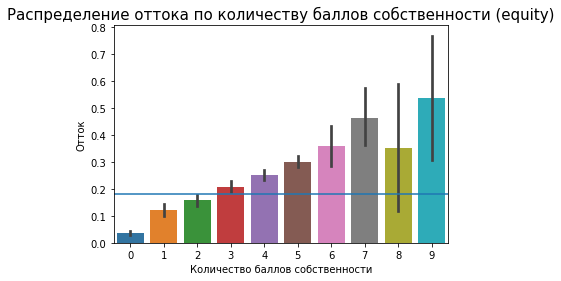

In [28]:
# распределение оттока по количеству баллов собственности (equity)
sns.barplot(data = data, x='equity', y='churn')
mean = data['churn'].mean()
plt.axhline(y=mean)
plt.title('Распределение оттока по количеству баллов собственности (equity)', fontsize=15)
plt.xlabel('Количество баллов собственности')
plt.ylabel('Отток');

На графике видно, что отток больше среднего по банку среди клиентов, у который 3-9 баллов собственности

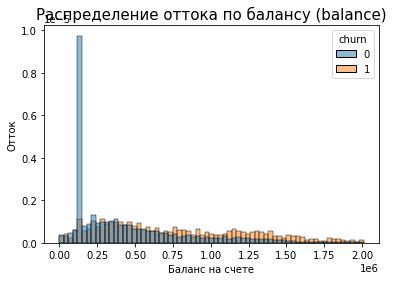

In [29]:
#распределение оттока по балансу (balance):
sns.histplot(data=data.query('balance < 2000000'), x='balance', hue='churn', stat='density', common_norm=False, binwidth=30000)
plt.title('Распределение оттока по балансу (balance)', fontsize=15)
plt.xlabel('Баланс на счете')
plt.ylabel('Отток');

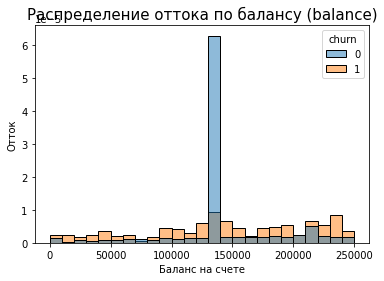

In [30]:
#Видно, что на одном из интервалов особенно сильный отток, посмотрим внимательнее на каком
sns.histplot(data=data.query('balance < 250000'), x='balance', hue='churn', stat='density', common_norm=False, binwidth=10000)
plt.title('Распределение оттока по балансу (balance)', fontsize=15)
plt.xlabel('Баланс на счете')
plt.ylabel('Отток');

На графике видно, что отток больше среднего по банку среди клиентов со суммой на счете до 130 тысяч или более 140 тысяч

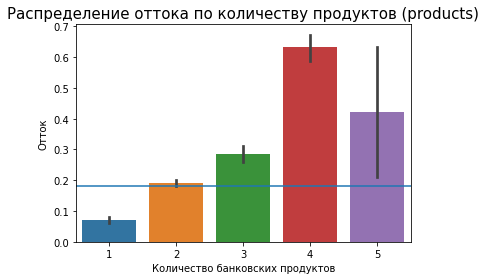

In [31]:
# распределение оттока по количеству продуктов (products)
sns.barplot(data = data, x='products', y='churn')
mean = data['churn'].mean()
plt.axhline(y=mean)
plt.title('Распределение оттока по количеству продуктов (products)', fontsize=15)
plt.xlabel('Количество банковских продуктов')
plt.ylabel('Отток');

На графике видно, что отток больше среднего по банку среди клиентов, у которых 3-5 банковских продуктов. (У клиентов с 2 кредитными продуктами отток почти совпадает со средним по банку, поэтому эту группу клиентов брать не будем).

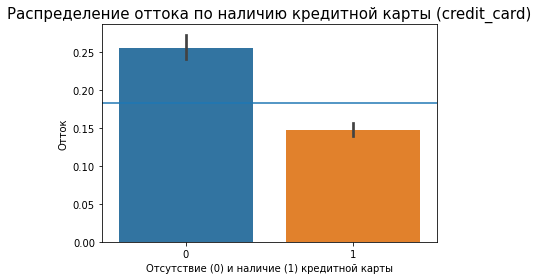

In [32]:
# распределение оттока по наличию кредитной карты (credit_card)
sns.barplot(data = data, x='credit_card', y='churn')
mean = data['churn'].mean()
plt.axhline(y=mean)
plt.title('Распределение оттока по наличию кредитной карты (credit_card)', fontsize=15)
plt.xlabel('Отсутствие (0) и наличие (1) кредитной карты')
plt.ylabel('Отток');

На графике видно, что отток больше среднего по банку у клиентов, не имеющих кредитной карты.

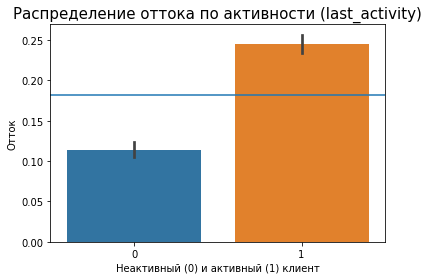

In [33]:
# распределение оттока по активности (last_activity)
sns.barplot(data = data, x='last_activity', y='churn')
mean = data['churn'].mean()
plt.axhline(y=mean)
plt.title('Распределение оттока по активности (last_activity)', fontsize=15)
plt.xlabel('Неактивный (0) и активный (1) клиент')
plt.ylabel('Отток');

На графике видно, что отток больше среднего по банку среди активных клиентов.

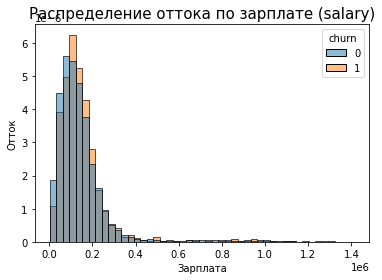

In [34]:
#распределение оттока по зарплате (salary):
sns.histplot(data=data, x='salary', hue='churn', stat='density', common_norm=False, binwidth=30000)
plt.title('Распределение оттока по зарплате (salary)', fontsize=15)
plt.xlabel('Зарплата')
plt.ylabel('Отток');

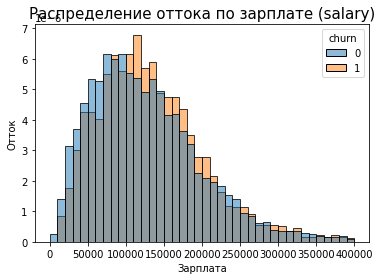

In [35]:
#посмотрим более внимательно
#распределение оттока по зарплате (salary):
sns.histplot(data=data.query('salary <400000'), x='salary', hue='churn', stat='density', common_norm=False, binwidth=10000, binrange=(0, 400000))
plt.title('Распределение оттока по зарплате (salary)', fontsize=15)
plt.xlabel('Зарплата')
plt.ylabel('Отток');

На графике видно, что отток больше среднего по банку среди клиентов с зарплатой 100-140 и 150-220 тыс

**Подытожим** результаты анализа распределения. Отток больше среднего по банку: 
- в промежутке с 820 до 900 баллов кредитного скоринга
- в Ярославле и Ростове
- среди мужчин
- среди возрастов 25-35, 50-60 лет
- среди клиентов, у который 3-9 баллов собственности
- среди клиентов со суммой на счете до 130 тысяч или более 140 тысяч
- среди клиентов, у которых 3-5 банковских продуктов
- у клиентов, не имеющих кредитной карты
- среди активных клиентов
- среди клиентов с зарплатой 100-140 и 150-220 тыс

### Корреляция. Исследуем корреляцию всех признаков таблицы

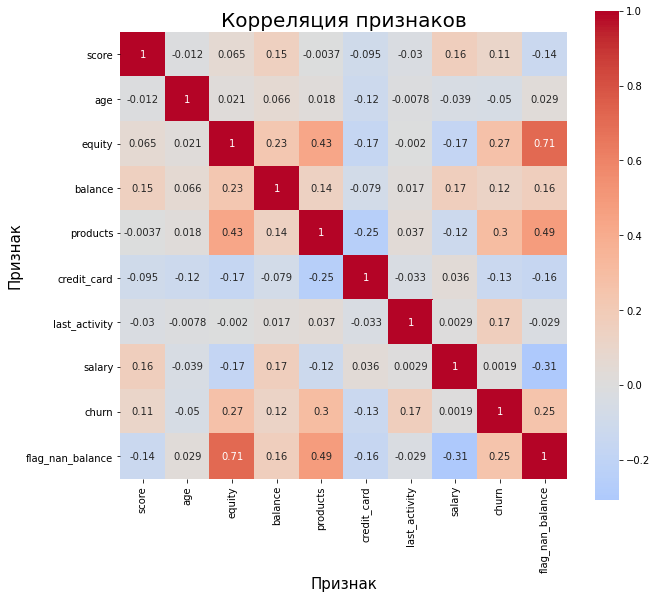

In [36]:
#построим матрицу корреляции для того, чтобы определить направление корреляции
cm = data.loc[:, data.columns != 'user_id'].corr()
fig, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(cm, annot=True, square=True, cmap='coolwarm', center=0)
plt.title('Корреляция признаков', fontsize = 20)
plt.xlabel('Признак', fontsize = 15)
plt.ylabel('Признак', fontsize = 15); 

In [37]:
# построим матрицу корреляции методом phik. Этот метод учитывает, какую величину мы оцениваем - категориальную или непрерывную.
print('Матрица корреляции методом phik:')
data.loc[:, data.columns != 'user_id'].phik_matrix(interval_cols=['score', 'age', 'balance', 'salary']).round(2)

Матрица корреляции методом phik:


,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,flag_nan_balance
score,1.00,0.09,0.07,0.03,0.53,0.15,0.42,0.21,0.05,0.40,0.23,0.75
city,0.09,1.00,0.01,0.09,0.06,0.03,0.13,0.07,0.03,0.17,0.02,0.04
gender,0.07,0.01,1.00,0.29,0.06,0.04,0.07,0.20,0.01,0.14,0.22,0.10
age,0.03,0.09,0.29,1.00,0.05,0.02,0.14,0.16,0.09,0.36,0.19,0.05
equity,0.53,0.06,0.06,0.05,1.00,0.00,0.58,0.22,0.05,0.29,0.35,0.98
balance,0.15,0.03,0.04,0.02,0.00,1.00,0.00,0.00,0.00,0.22,0.03,0.01
products,0.42,0.13,0.07,0.14,0.58,0.00,1.00,0.27,0.11,0.22,0.26,0.49
credit_card,0.21,0.07,0.20,0.16,0.22,0.00,0.27,1.00,0.05,0.04,0.20,0.24
last_activity,0.05,0.03,0.01,0.09,0.05,0.00,0.11,0.05,1.00,0.04,0.26,0.04
salary,0.40,0.17,0.14,0.36,0.29,0.22,0.22,0.04,0.04,1.00,0.05,0.43


Оцениваем корреляцию оттока (churn) с остальными признаками. Для этого используем шкалу Чеддока.

Шкала Чеддока:

Количественная мера тесноты связи; Качественная характеристика силы связи

0,1 - 0,3 Слабая

0,3 - 0,5 Умеренная

0,5 - 0,7 Заметная

0,7 - 0,9 Высокая

0,9 - 0,99 Весьма высокая

Согдасно таблице Чеддока:

- У параметров salary (0.05), balance (0.03) и city (0.02) связь отсутствует
- У параметров age (0.19) и credit_card (0.2) связь слабая, отрицательная
- У параметров score (0.23), gender (0.22), products (0.26) и last_activity(0.26) связь слабая положительная
- У параметра equity (0.35) связь умеренная

(Направление корреляции взято с графика выше)

**Подытожим**
Таким образом, параметр equity(количество баллов собственности) коррелирует с оттоком умеренно, остальные величины имеют слабую связь или не имеют вообще.

### Портрет клиента
Создадим таблицу, описывающую портрет клиента по всем признакам:

In [38]:
aggregations = {'score':'median', 'age':'median', 'balance':'median', 'salary':'median', 'city':lambda x:x.mode()[0], 'gender':lambda x:x.mode()[0], 'equity':lambda x:x.mode()[0], 'products':lambda x:x.mode()[0], 'credit_card':lambda x:x.mode()[0], 'last_activity':lambda x:x.mode()[0],'city':lambda x:x.mode()[0]}

In [39]:
client_portrait = data.groupby('churn').agg(aggregations).reset_index().transpose()

In [40]:
print('Портрет клиента (1-отточный клиент, 0-лояльный клиент):')
client_portrait

Портрет клиента (1-отточный клиент, 0-лояльный клиент):


,0,1
churn,0,1
score,848.0,866.0
age,40.0,39.0
balance,321642.56,775399.47
salary,118227.6,125408.88
city,Ярославль,Ярославль
gender,Ж,М
equity,0,5
products,2,2
credit_card,1,1


**Вывод**

Видим, что признаки имеют одинаковое значение у:
- age (разница в 1 год незначительна)
- salary (входит в один диапазон)
- city
- products
- credit_card

Признаки имеют разные значения у:
- score
- balance (примерно в 2 раза)
- gender
- equity
- last_activity

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

Портрет клиента корректный. Молодец

## Проверка статистических гипотез

### Проверим гипотезу различия дохода между лояльными и отточными клиентами

Сначала определим имеет ли salary нормальное распределение (т.к. статистический t-test является приоритетным). Для этого используем Критерий Шапиро-Уилка:

In [41]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(data['salary'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Распределение не нормально (это заметно и на гистограмме). Есть выбросы, которые влияют на распределение, поэтому использовать t-test нельзя.
Так как величина непрерывная используем непараметрический тест Уилкоксона-Манна-Уитни (u-test):

**Сформулируем гипотезы:**

- Нулевая гипотеза (Н0): статистически значимых различий между доходами лояльных клиентов и отточных клиентов нет.
- Альтернативная гипотеза (Н1): есть статистически значимые различия между доходами лояльных клиентов и отточных клиентов. 

In [42]:
churn_client = data.query('churn == 1')['salary']
loyal_client = data.query('churn == 0')['salary']

alpha = 0.5  # критический уровень статистической значимости

results = st.mannwhitneyu(churn_client, loyal_client)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
print('Относительное различие в медианной зарплате лояльных и отточных клиентов -', "{0:.2f}%".format((churn_client.median()-loyal_client.median())*100/churn_client.median()) )   

p-значение:  0.00016830729188229058
Отвергаем нулевую гипотезу: разница статистически значима
Относительное различие в медианной зарплате лояльных и отточных клиентов - 5.73%


Таким образом, наша гипотеза была отвергнута. Есть статистически значимая разница в доходах клиентов. Она составляет 5,73%.

### Проверим гипотезу различия в баллах кредитного скоринга между лояльными и отточными клиентами

Сначала определим имеет ли score нормальное распределение. Для этого используем Критерий Шапиро-Уилка:

In [43]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(data['score'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  9.527601434937905e-28
Отвергаем нулевую гипотезу: распределение не нормально


Распределение не нормально. Есть выбросы, которые влияют на распределение, поэтому использовать t-test нельзя. Так как величина непрерывная используем непараметрический тест Уилкоксона-Манна-Уитни (u-test):

**Сформулируем гипотезы:**

- Нулевая гипотеза (Н0): статистически значимых различий между баллами кредитного скоринга лояльных клиентов и отточных клиентов нет.
- Альтернативная гипотеза (Н1): есть статистически значимые различия между между баллами кредитного скоринга лояльных клиентов и отточных клиентов.

In [44]:
churn_client = data.query('churn == 1')['score']
loyal_client = data.query('churn == 0')['score']

alpha = 0.5  # критический уровень статистической значимости

results = st.mannwhitneyu(churn_client, loyal_client)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
print('Относительное различие в медианной разплате лояльных и отточных клиентов -', "{0:.2f}%".format((churn_client.median()-loyal_client.median())*100/churn_client.median()) )   

p-значение:  4.508763537702903e-22
Отвергаем нулевую гипотезу: разница статистически значима
Относительное различие в медианной разплате лояльных и отточных клиентов - 2.08%


Таким образом, наша гипотеза была отвергнута. Есть статистически значимая разница между баллами кредитного скоринга у лояльных и отточных клиентов. Она составляет 2,08%.

**Вывод**

Есть статистически значимая разница в доходах лояльных и отточных клиентов. Она составляет 5,73%.
Есть статистически значимая разница между баллами кредитного скоринга у лояльных и отточных клиентов. Она составляет 2,08%.

## Промежуточные итоги

Сделаем выводы по результатам EDA, корреляционного анализа и гипотез, выделим признаки, влияющие на отток

**Результаты анализа распределения. Отток больше среднего по банку:** 
- в промежутке с 820 до 900 баллов кредитного скоринга
- в Ярославле и Ростове
- среди мужчин
- среди возрастов 25-35, 50-60 лет
- среди клиентов, у который 3-9 баллов собственности
- среди клиентов со суммой на счете до 130 тысяч или более 140 тысяч
- среди клиентов, у которых 3-5 банковских продуктов
- у клиентов, не имеющих кредитной карты
- среди активных клиентов
- среди клиентов с зарплатой 100-140 и 150-220 тыс

**Корреляция оттока (churn) с остальными признаками**
- У параметров salary, balance и city связь отсутствует
- У параметров age и credit_card связь слабая, отрицательная
- У параметров score, gender, products и last_activity связь слабая положительная
- У параметра equity связь умеренная

Таким образом, параметр equity(количество баллов собственности) коррелирует с оттоком умеренно, остальные величины имеют слабую связь или не имеют вообще.

**Портрет клиента**

Видим, что признаки имеют одинаковое значение у:
- age (разница в 1 год незначительна)
- salary (входит в один диапазон)
- city
- products
- credit_card

Признаки имеют разные значения у:
- score
- balance (примерно в 2 раза)
- gender
- equity
- last_activity

**Статистические гипотезы**

Есть статистически значимая разница в доходах лояльных и отточных клиентов. Она составляет 5,73%.

Есть статистически значимая разница между баллами кредитного скоринга у лояльных и отточных клиентов. Она составляет 2,08%.

Для сегментации клиентов удобно будет использовать портрет отточного клиента, совмещенный с результатами анализа распределения, так же нужно будет учесть признаки, которые имеют разное значение в портрете клиента.

## Сегментация

Задача создать сегменты с мин кол-вом 500 человек с оттоком выше, чем отток по банку. Для этого распределим признаки так, чтобы их сочетание давало сегмент около 500 человек.

**Первый сегмент**

В первый сегмент добавили клиентов с параметрами:
- баллы кредитного скоринга с 820 до 900 
- посещают банк в Ярославле
- мужчины

In [45]:
segment_1 = data.query('gender == "М" and city == "Ярославль" and 820 < score < 900 and last_activity == 1')

In [46]:
print('Количество клиентов в сегменте:', segment_1['user_id'].count())

Количество клиентов в сегменте: 518


In [47]:
print('Количество отточных клиентов в сегменте:', segment_1['churn'].sum())

Количество отточных клиентов в сегменте: 261


In [48]:
print('Уровень оттока в сегменте:', segment_1['churn'].mean().round(2))

Уровень оттока в сегменте: 0.5


**Второй сегмент**

Во второй сегмент добавили пользователей с параметрами:
- возраст 25-30, 50-60 лет
-  5-9 баллов собственности (3 и 4 брать не стали для сужения сегмента, у них ооточность меньше, чем у 5 - 9 баллов)
- клиенты со суммой на счете до 130 тысяч или более 140 тысяч

In [49]:
segment_2 = data.query('5 <= equity <= 9 and (balance <= 130000 or balance >= 140000) and (25 <= age <= 35 or 50 <= age <= 60)')

In [50]:
print('Количество клиентов в сегменте:', segment_2['user_id'].count())

Количество клиентов в сегменте: 1104


In [51]:
print('Количество отточных клиентов в сегменте:', segment_2['churn'].sum())

Количество отточных клиентов в сегменте: 426


In [52]:
print('Уровень оттока в сегменте:', segment_2['churn'].mean().round(2))

Уровень оттока в сегменте: 0.39


**Третий сегмент**

Во третий сегмент добавили пользователей с параметрами:
- клиенты, не имеющие кредитной карты
- активные клиентов
- зарплатой 100-140 и 150-220 тыс

In [53]:
segment_3 = data.query('last_activity == 1 and credit_card == 0 and (100000 < salary< 140000 or 150000 < salary < 220000)')

In [54]:
print('Количество клиентов в сегменте:', segment_3['user_id'].count())

Количество клиентов в сегменте: 737


In [55]:
print('Количество отточных клиентов в сегменте:', segment_3['churn'].sum())

Количество отточных клиентов в сегменте: 310


In [56]:
print('Уровень оттока в сегменте:', segment_3['churn'].mean().round(2))

Уровень оттока в сегменте: 0.42


**Четвертый сегмент**

Во четвертый сегмент добавили пользователей с параметром количество продуктов 4 и больше, так как на этот сегмент набирается почти 500 человек

In [57]:
segment_4 = data.query('products >=4')

In [58]:
print('Количество клиентов в сегменте:', segment_4['user_id'].count())

Количество клиентов в сегменте: 493


In [59]:
print('Количество отточных клиентов в сегменте:', segment_4['churn'].sum())

Количество отточных клиентов в сегменте: 308


In [60]:
print('Уровень оттока в сегменте:', segment_4['churn'].mean().round(2))

Уровень оттока в сегменте: 0.62


## Приоритезация сегментов

Приоритизируем сегменты по мере убывания отточных клиентов:
1. Четвертый сегмент (отток 0,62):
     - количество продуктов 4 и больше
2. Первый сегмент (отток 0,5)
    - баллы кредитного скоринга с 820 до 900
    - посещают банк в Ярославле
    - мужчины
3. Третий сегмент (отток 0,42)
    - клиенты, не имеющие кредитной карты
    - активные клиенты
    - с зарплатой 100-140 и 150-220 тыс
4. Второй сегмент (отток 0,39)
    - возраст 25-35, 50-60 лет
    - 5-9 баллов собственности
    - клиенты со суммой на счете до 130 тысяч или более 140 тысяч    

## Рекомендация по работе с сегментами отточных клиентов:


**Четвертый сегмент**
- Добавить разных активностей, акций и бонусов. Ведь банк покидают активные клиенты с большим количеством продуктов. Для таких постоянные акции и спец. предложения будут актуальны.
- Уточнить, легко ли в банке закрыть какой-либо из продуктов. Например клиент хочет закрыть дебетовую карту и выясняет, что через мобильное приложение этого сделать нельзя, нужно идти в банк. Времени на это нет и клиент не может ибавиться от ненужного продукта, тем временем плата списывается ежемесячно. Это приводит к отказу клиента пользоваться банком. В таком случае отказ от продуктов нужно реализовать через мобильное приложение.

**Первый сегмент**
- Проверить часы работы отделений в Ярославле и Ростове. Возможно, банки не работают по субботам и многие люди не могут попасть в банк в рабочее время.
- Проверить наличие очереди в отделениях и если очереди присутствуют на постоянной основе (час и больше), то это отталкивает клиентов. В таком случаем нужно сделать предварительную запись и большинство операций перенести в мобильное приложени или онлайн-банк.
- Так как банк покидают преимущественно мужчины, то стоит предлагать повышенный кэшбек за "мужские траты": кашбек за АЗС, бары и рестораны, вино-водочные магазины и т.д.

**Третий сегмент**
- Активнее предлагать клиентам кредитную карту: устраивать акции, делеть специальные предложения для клиентов банка, дать рекламу кредитной карты. Мы видим, что клиенты с кредитной картой более лояльны. Возможно это потому что наша кредитная карта действительно нравится пользователям.
- Улучшить мобильное приложение и онлайн-банк. Так как активные клиенты менее лояльны, то можно предположить что им не удобно пользоваться мобильным приложением и онлайн-банком.

**Второй сегмент**
- Предлагать клиентам разные бонусы за совершение операций в мобильном приложении, по сравнению с походом в офис. Многие клиенты (особенно постарше) предпочитают пойти в офис, вместо мобильного предложения (МП). Это создает очереди. Таким клиентам можно предлогать повышенный процент по накопительному счету, при открытии в МП, пониженную ставку за оформление кредита в МП.
- Предлагать больше кредитов с пониженной ставкой за передачу имущества под залог банку. Потому что в данном сегменте клиенты с большим количеством баллов собственности
- Придложить повышенную ставку за содержание на вкладе или накопительном счете суммы 130-140 тыс рублей, т.к. клиенты с такими суммами активно покидают банк.

## Вывод:

Была поставлена задача: проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка

Для выполнения задачи мы:

1. Загрузили данные
2. Выполнили предобработку данных
 - заполнили пропуски
 - удалили дубликаты
 - удалили аномалии
3. Выполнили анализ данных 
 - сделали анализ распределения и нашли признаки отточных клиентов
 - отобразили корреляцию признаков с отточностью
 - составили портрет отточного клиента
4. Предложили 2 статистические гипотезы и проверили их
5. Сегментировали клиентов (создали 4 сегмента)
6. Предложили рекомендации для работы с отточными клиентами

**Таким образом мы определили сегменты отточных клиентов и предложили рекомендации для работы с ними.** Поставленная задача была выполнена